# DAX Directional Persistence Conditioned on Volatility Regime
## Does Today's Direction Persist Tomorrow, Conditioned on Today's Volatility Regime?

**Objective:** Test whether today's direction (Up/Down) predicts tomorrow's direction, separately for each volatility regime (Low/Normal/High).

**Key Question:**
- In Low volatility regime: If today is UP, is tomorrow more likely UP or DOWN?
- In High volatility regime: Does the pattern differ?
- Can we detect regime-dependent momentum vs mean-reversion?

**Hypothesis:**
- H0: Direction tomorrow is independent of direction today (within each regime, P(dir_next|dir_today) ≈ 50%)
- H1: Patterns exist (some regimes show momentum, others show reversal)

**Data:** M5 OHLCV bars, Jan 2023 – Sept 2025, UTC → Berlin time (pytz auto DST), RTH only (09:00-17:30)

**Critical Constraint:** Each day's regime uses only prior 60 days (no look-ahead bias).

---


## Part 1: Data Preparation


In [1]:
import sys
sys.path.insert(0, '../../')

from shared.database_connector import fetch_ohlcv, get_date_range
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print('[OK] Dependencies loaded')
print('='*80)

[OK] Dependencies loaded


## Step 1: Fetch M5 Data and Aggregate to Daily


In [2]:
print('\n[STEP 1] Fetch M5 Data and Aggregate to Daily Level')
print('='*80)

# Get available date range
date_range = get_date_range('deuidxeur', 'm5')
end_date = date_range['end']
start_date = end_date - timedelta(days=730)  # ~2 years

print(f'Fetching M5 data: {start_date.date()} to {end_date.date()}')

# Fetch M5 data
df_raw = fetch_ohlcv(
    symbol='deuidxeur',
    timeframe='m5',
    start_date=start_date,
    end_date=end_date
)

# Convert to Berlin time
df = df_raw.copy()
df.index = df.index.tz_convert('Europe/Berlin')

print(f'[OK] Fetched {len(df)} M5 candles')

# Extract time components
df['date'] = df.index.date
df['hour'] = df.index.hour
df['minute'] = df.index.minute

# Filter to RTH
df_rth = df[(df['hour'] >= 9) & ((df['hour'] < 17) | ((df['hour'] == 17) & (df['minute'] <= 30)))].copy()

print(f'[OK] Filtered to RTH (09:00-17:30): {len(df_rth)} candles')

# Calculate True Range
df_rth['c_prev'] = df_rth['close'].shift(1)
day_boundary = df_rth['date'] != df_rth['date'].shift(1)
df_rth.loc[day_boundary, 'c_prev'] = np.nan

df_rth['hl_range'] = df_rth['high'] - df_rth['low']
df_rth['h_cp_range'] = (df_rth['high'] - df_rth['c_prev']).abs()
df_rth['l_cp_range'] = (df_rth['low'] - df_rth['c_prev']).abs()
df_rth['tr'] = df_rth[['hl_range', 'h_cp_range', 'l_cp_range']].max(axis=1)
df_rth.loc[day_boundary, 'tr'] = df_rth.loc[day_boundary, 'hl_range']

print(f'[OK] Calculated True Range for all M5 bars')

2025-11-29 14:40:58,300 - shared.database_connector - INFO - Initializing database connection...
2025-11-29 14:40:58,301 - shared.database_connector - WARNING - CA certificate not found at certs\ca-certificate.crt. Connecting without SSL verification.



[STEP 1] Fetch M5 Data and Aggregate to Daily Level


2025-11-29 14:40:58,966 - shared.database_connector - INFO - [OK] Database connection successful
2025-11-29 14:40:59,278 - shared.database_connector - INFO - [OK] Date range for deuidxeur m5: 2023-01-08 23:00:00+00:00 to 2025-09-16 21:55:00+00:00
2025-11-29 14:40:59,279 - shared.database_connector - INFO - fetch_ohlcv(): symbol=deuidxeur, timeframe=m5, start=2023-09-17 21:55:00+00:00, end=2025-09-16 21:55:00+00:00


Fetching M5 data: 2023-09-17 to 2025-09-16


2025-11-29 14:41:01,193 - shared.database_connector - INFO - [OK] Fetched 136661 candles (2023-09-17 21:55:00+00:00 to 2025-09-16 21:55:00+00:00)


[OK] Fetched 136661 M5 candles
[OK] Filtered to RTH (09:00-17:30): 53005 candles
[OK] Calculated True Range for all M5 bars


## Step 2: Aggregate to Daily and Calculate Regimes (No Look-Ahead)


In [3]:
print('\n[STEP 2] Aggregate to Daily Level and Assign Regimes')
print('='*80)

daily_data = []

for date, day_data in df_rth.groupby('date'):
    if len(day_data) < 12:
        continue
    
    daily_open = day_data.iloc[0]['open']
    daily_close = day_data.iloc[-1]['close']
    daily_tr_sum = day_data['tr'].sum()
    atrp = (daily_tr_sum / daily_close) * 100 if daily_close > 0 else 0
    
    daily_return = (daily_close / daily_open - 1) * 100 if daily_open > 0 else 0
    
    row = {
        'date': date,
        'daily_open': daily_open,
        'daily_close': daily_close,
        'daily_return': daily_return,
        'daily_tr_sum': daily_tr_sum,
        'atrp': atrp,
        'n_bars': len(day_data),
    }
    daily_data.append(row)

df_daily = pd.DataFrame(daily_data).sort_values('date').reset_index(drop=True)

print(f'[OK] Aggregated to {len(df_daily)} trading days')
print(f'Date range: {df_daily["date"].min()} to {df_daily["date"].max()}')

# Volatility regime labeling (no look-ahead)
def rolling_percentile_rank(series, window=61):
    """Calculate percentile rank with no look-ahead bias."""
    ranks = []
    for i in range(len(series)):
        if i < window - 1:
            ranks.append(np.nan)
        else:
            prior_window = series.iloc[i - window + 1: i].values
            current_value = series.iloc[i]
            rank = stats.percentileofscore(prior_window, current_value)
            ranks.append(rank)
    return ranks

df_daily['atrp_percentile_rank'] = rolling_percentile_rank(df_daily['atrp'], window=61)

def label_regime(percentile):
    if pd.isna(percentile):
        return 'Unknown'
    elif percentile < 33.33:
        return 'Low'
    elif percentile < 66.67:
        return 'Normal'
    else:
        return 'High'

df_daily['regime'] = df_daily['atrp_percentile_rank'].apply(label_regime)

# Filter to valid regimes
df_daily_valid = df_daily[df_daily['regime'] != 'Unknown'].reset_index(drop=True)

print(f'[OK] Assigned regimes using 60-day rolling percentile (no look-ahead)')
print(f'Valid regime days: {len(df_daily_valid)}')

# Regime distribution
print(f'\nRegime Distribution (should be ~33% each):')
for regime in ['Low', 'Normal', 'High']:
    count = (df_daily_valid['regime'] == regime).sum()
    pct = count / len(df_daily_valid) * 100
    print(f'  {regime:8} {count:4d} days ({pct:5.1f}%)')


[STEP 2] Aggregate to Daily Level and Assign Regimes
[OK] Aggregated to 515 trading days
Date range: 2023-09-18 to 2025-09-16
[OK] Assigned regimes using 60-day rolling percentile (no look-ahead)
Valid regime days: 455

Regime Distribution (should be ~33% each):
  Low       167 days ( 36.7%)
  Normal    141 days ( 31.0%)
  High      147 days ( 32.3%)


## Step 3: Direction Classification and Day Pairs (Forward-Looking)


In [4]:
print('\n[STEP 3] Direction Classification and Create Day Pairs')
print('='*80)

# Direction of daily return
df_daily_valid['direction'] = np.sign(df_daily_valid['daily_return'])

# Replace direction == 0 with NaN (flat days)
df_daily_valid['direction'] = df_daily_valid['direction'].replace(0, np.nan)

# Create forward-looking pairs (shift -1 means look at next row = tomorrow)
df_daily_valid['direction_next'] = df_daily_valid['direction'].shift(-1)
df_daily_valid['regime_next'] = df_daily_valid['regime'].shift(-1)

# Drop last day (no next day)
df_pairs = df_daily_valid[df_daily_valid['direction_next'].notna()].copy()
# Also drop if either direction is NaN
df_pairs = df_pairs[df_pairs['direction'].notna()].copy()

print(f'[OK] Created {len(df_pairs)} day pairs')
print(f'Example: {df_pairs.iloc[0]["date"]} (dir={df_pairs.iloc[0]["direction"]:+.0f}, regime={df_pairs.iloc[0]["regime"]}) → '
      f'{df_pairs.iloc[1]["date"]} (dir={df_pairs.iloc[1]["direction"]:+.0f})')

print(f'\nDirection distribution (today):')
print(f'  Up   (+1): {(df_pairs["direction"] > 0).sum()} days')
print(f'  Down (-1): {(df_pairs["direction"] < 0).sum()} days')


[STEP 3] Direction Classification and Create Day Pairs
[OK] Created 454 day pairs
Example: 2023-12-11 (dir=+1, regime=Low) → 2023-12-12 (dir=-1)

Direction distribution (today):
  Up   (+1): 248 days
  Down (-1): 206 days


## Step 4: Directional Transition Matrix (Global)


In [5]:
print('\n[STEP 4] Global Directional Transition Matrix')
print('='*80)

# Create 2x2 transition matrix
up_up = ((df_pairs['direction'] > 0) & (df_pairs['direction_next'] > 0)).sum()
up_down = ((df_pairs['direction'] > 0) & (df_pairs['direction_next'] < 0)).sum()
down_up = ((df_pairs['direction'] < 0) & (df_pairs['direction_next'] > 0)).sum()
down_down = ((df_pairs['direction'] < 0) & (df_pairs['direction_next'] < 0)).sum()

n_up = up_up + up_down
n_down = down_up + down_down

print(f'\n[2x2 TRANSITION MATRIX - All Days]')
print(f'\nRows: Today\'s direction | Columns: Tomorrow\'s direction\n')
print(f'              Tomorrow UP  Tomorrow DOWN')
print(f'Today UP     {up_up:>6d} ({up_up/n_up*100:>5.1f}%)    {up_down:>6d} ({up_down/n_up*100:>5.1f}%)')
print(f'Today DOWN   {down_up:>6d} ({down_up/n_down*100:>5.1f}%)    {down_down:>6d} ({down_down/n_down*100:>5.1f}%)')

p_cont_up = up_up / n_up if n_up > 0 else 0
p_cont_down = down_down / n_down if n_down > 0 else 0

print(f'\n[GLOBAL PERSISTENCE]')
print(f'P(UP → UP)   = {p_cont_up:.1%} (baseline for random: 50%)')
print(f'P(DOWN → DOWN) = {p_cont_down:.1%} (baseline for random: 50%)')
print(f'Average persistence: {(p_cont_up + p_cont_down)/2:.1%}')

# Binomial tests
print(f'\n[SIGNIFICANCE TESTS]')

binom_up = stats.binomtest(up_up, n_up, 0.5, alternative='two-sided')
binom_down = stats.binomtest(down_down, n_down, 0.5, alternative='two-sided')

print(f'\nUP → UP: {up_up} / {n_up}')
print(f'  H0: P(UP→UP) = 0.5')
print(f'  Observed: {p_cont_up:.4f}')
print(f'  p-value: {binom_up.pvalue:.4f} {"[SIGNIFICANT]" if binom_up.pvalue < 0.05 else "[NOT SIG]"}')

print(f'\nDOWN → DOWN: {down_down} / {n_down}')
print(f'  H0: P(DOWN→DOWN) = 0.5')
print(f'  Observed: {p_cont_down:.4f}')
print(f'  p-value: {binom_down.pvalue:.4f} {"[SIGNIFICANT]" if binom_down.pvalue < 0.05 else "[NOT SIG]"}')


[STEP 4] Global Directional Transition Matrix

[2x2 TRANSITION MATRIX - All Days]

Rows: Today's direction | Columns: Tomorrow's direction

              Tomorrow UP  Tomorrow DOWN
Today UP        133 ( 53.6%)       115 ( 46.4%)
Today DOWN      114 ( 55.3%)        92 ( 44.7%)

[GLOBAL PERSISTENCE]
P(UP → UP)   = 53.6% (baseline for random: 50%)
P(DOWN → DOWN) = 44.7% (baseline for random: 50%)
Average persistence: 49.1%

[SIGNIFICANCE TESTS]

UP → UP: 133 / 248
  H0: P(UP→UP) = 0.5
  Observed: 0.5363
  p-value: 0.2803 [NOT SIG]

DOWN → DOWN: 92 / 206
  H0: P(DOWN→DOWN) = 0.5
  Observed: 0.4466
  p-value: 0.1432 [NOT SIG]


## Step 5: Regime-Specific 2x2 Matrices (LOW Volatility)


In [6]:
print('\n[STEP 5] Regime-Specific Transition Matrices')
print('='*80)

# Function to create and analyze regime-specific matrix
def analyze_regime_transitions(df, regime_name):
    regime_data = df[df['regime'] == regime_name].copy()
    
    if len(regime_data) < 10:
        print(f'\n{regime_name}: Not enough data ({len(regime_data)} days)')
        return None
    
    # 2x2 matrix
    up_up = ((regime_data['direction'] > 0) & (regime_data['direction_next'] > 0)).sum()
    up_down = ((regime_data['direction'] > 0) & (regime_data['direction_next'] < 0)).sum()
    down_up = ((regime_data['direction'] < 0) & (regime_data['direction_next'] > 0)).sum()
    down_down = ((regime_data['direction'] < 0) & (regime_data['direction_next'] < 0)).sum()
    
    n_up = up_up + up_down
    n_down = down_up + down_down
    n_total = n_up + n_down
    
    if n_up == 0 or n_down == 0:
        print(f'\n{regime_name}: Insufficient data in one direction')
        return None
    
    p_cont_up = up_up / n_up
    p_cont_down = down_down / n_down
    
    print(f'\n\n["{regime_name.upper()}" VOLATILITY REGIME] ({n_total} day pairs)')
    print('='*90)
    print(f'\n              Tomorrow UP  Tomorrow DOWN')
    print(f'Today UP     {up_up:>6d} ({up_up/n_up*100:>5.1f}%)    {up_down:>6d} ({up_down/n_up*100:>5.1f}%)')
    print(f'Today DOWN   {down_up:>6d} ({down_up/n_down*100:>5.1f}%)    {down_down:>6d} ({down_down/n_down*100:>5.1f}%)')
    
    print(f'\n[PERSISTENCE]')
    print(f'P(UP → UP)     = {p_cont_up:.1%}')
    print(f'P(DOWN → DOWN) = {p_cont_down:.1%}')
    print(f'Average        = {(p_cont_up + p_cont_down)/2:.1%}')
    
    # Binomial tests
    print(f'\n[SIGNIFICANCE]')
    
    binom_up = stats.binomtest(up_up, n_up, 0.5, alternative='two-sided') if n_up >= 5 else None
    binom_down = stats.binomtest(down_down, n_down, 0.5, alternative='two-sided') if n_down >= 5 else None
    
    if binom_up:
        sig_up = 'YES' if binom_up.pvalue < 0.05 else 'NO'
        print(f'UP → UP:       p-value = {binom_up.pvalue:.4f} [{sig_up}]')
    else:
        print(f'UP → UP:       n < 5, skipping test')
    
    if binom_down:
        sig_down = 'YES' if binom_down.pvalue < 0.05 else 'NO'
        print(f'DOWN → DOWN:   p-value = {binom_down.pvalue:.4f} [{sig_down}]')
    else:
        print(f'DOWN → DOWN:   n < 5, skipping test')
    
    # Pattern classification
    print(f'\n[PATTERN CLASSIFICATION]')
    
    if p_cont_up > 0.55 or p_cont_down > 0.55:
        pattern = 'SLIGHT MOMENTUM'
    elif p_cont_up < 0.45 or p_cont_down < 0.45:
        pattern = 'SLIGHT MEAN-REVERSION'
    else:
        pattern = 'MIXED / BALANCED'
    
    print(f'{pattern}')
    
    return {
        'regime': regime_name,
        'n_total': n_total,
        'n_up': n_up,
        'n_down': n_down,
        'p_cont_up': p_cont_up,
        'p_cont_down': p_cont_down,
        'avg_persistence': (p_cont_up + p_cont_down) / 2,
        'pattern': pattern,
    }

results_regimes = []

for regime in ['Low', 'Normal', 'High']:
    res = analyze_regime_transitions(df_pairs, regime)
    if res:
        results_regimes.append(res)

df_results_regimes = pd.DataFrame(results_regimes)


[STEP 5] Regime-Specific Transition Matrices


["LOW" VOLATILITY REGIME] (167 day pairs)

              Tomorrow UP  Tomorrow DOWN
Today UP         57 ( 53.3%)        50 ( 46.7%)
Today DOWN       31 ( 51.7%)        29 ( 48.3%)

[PERSISTENCE]
P(UP → UP)     = 53.3%
P(DOWN → DOWN) = 48.3%
Average        = 50.8%

[SIGNIFICANCE]
UP → UP:       p-value = 0.5621 [NO]
DOWN → DOWN:   p-value = 0.8974 [NO]

[PATTERN CLASSIFICATION]
MIXED / BALANCED


["NORMAL" VOLATILITY REGIME] (141 day pairs)

              Tomorrow UP  Tomorrow DOWN
Today UP         45 ( 53.6%)        39 ( 46.4%)
Today DOWN       32 ( 56.1%)        25 ( 43.9%)

[PERSISTENCE]
P(UP → UP)     = 53.6%
P(DOWN → DOWN) = 43.9%
Average        = 48.7%

[SIGNIFICANCE]
UP → UP:       p-value = 0.5856 [NO]
DOWN → DOWN:   p-value = 0.4270 [NO]

[PATTERN CLASSIFICATION]
SLIGHT MEAN-REVERSION


["HIGH" VOLATILITY REGIME] (146 day pairs)

              Tomorrow UP  Tomorrow DOWN
Today UP         31 ( 54.4%)        26 ( 45.6%)
Today DOWN   

## Step 6: Summary Comparison Table


In [7]:
print('\n[STEP 6] Regime Comparison Summary')
print('='*80)

if len(df_results_regimes) > 0:
    print(f'\n[SUMMARY TABLE: Directional Persistence by Regime]\n')
    print(f'{"Regime":<12} {"N Days":>8} {"P(UP→UP)":>10} {"P(DN→DN)":>10} {"Avg Pers":>10} {"Pattern":<25}')
    print('='*85)
    
    for _, row in df_results_regimes.iterrows():
        print(f'{row["regime"]:<12} {row["n_total"]:>8d} {row["p_cont_up"]:>9.1%}  {row["p_cont_down"]:>9.1%}  {row["avg_persistence"]:>9.1%}  {row["pattern"]:<25}')
    
    print(f'\n[KEY FINDINGS]\n')
    
    # Find strongest persistence
    strongest_idx = df_results_regimes['avg_persistence'].idxmax()
    strongest = df_results_regimes.iloc[strongest_idx]
    
    print(f'Strongest persistence: {strongest["regime"]} regime ({strongest["avg_persistence"]:.1%})')
    print(f'  - UP → UP: {strongest["p_cont_up"]:.1%}')
    print(f'  - DOWN → DOWN: {strongest["p_cont_down"]:.1%}')
    
    # Find most asymmetric
    df_results_regimes['asymmetry'] = (df_results_regimes['p_cont_up'] - df_results_regimes['p_cont_down']).abs()
    most_asym_idx = df_results_regimes['asymmetry'].idxmax()
    most_asym = df_results_regimes.iloc[most_asym_idx]
    
    print(f'\nMost asymmetric: {most_asym["regime"]} regime')
    print(f'  - UP → UP: {most_asym["p_cont_up"]:.1%}')
    print(f'  - DOWN → DOWN: {most_asym["p_cont_down"]:.1%}')
    print(f'  - Difference: {abs(most_asym["p_cont_up"] - most_asym["p_cont_down"]):.1%}')


[STEP 6] Regime Comparison Summary

[SUMMARY TABLE: Directional Persistence by Regime]

Regime         N Days   P(UP→UP)   P(DN→DN)   Avg Pers Pattern                  
Low               167     53.3%      48.3%      50.8%  MIXED / BALANCED         
Normal            141     53.6%      43.9%      48.7%  SLIGHT MEAN-REVERSION    
High              146     54.4%      42.7%      48.5%  SLIGHT MEAN-REVERSION    

[KEY FINDINGS]

Strongest persistence: Low regime (50.8%)
  - UP → UP: 53.3%
  - DOWN → DOWN: 48.3%

Most asymmetric: High regime
  - UP → UP: 54.4%
  - DOWN → DOWN: 42.7%
  - Difference: 11.7%


## Step 7: Visualizations



[STEP 7] Visualizations


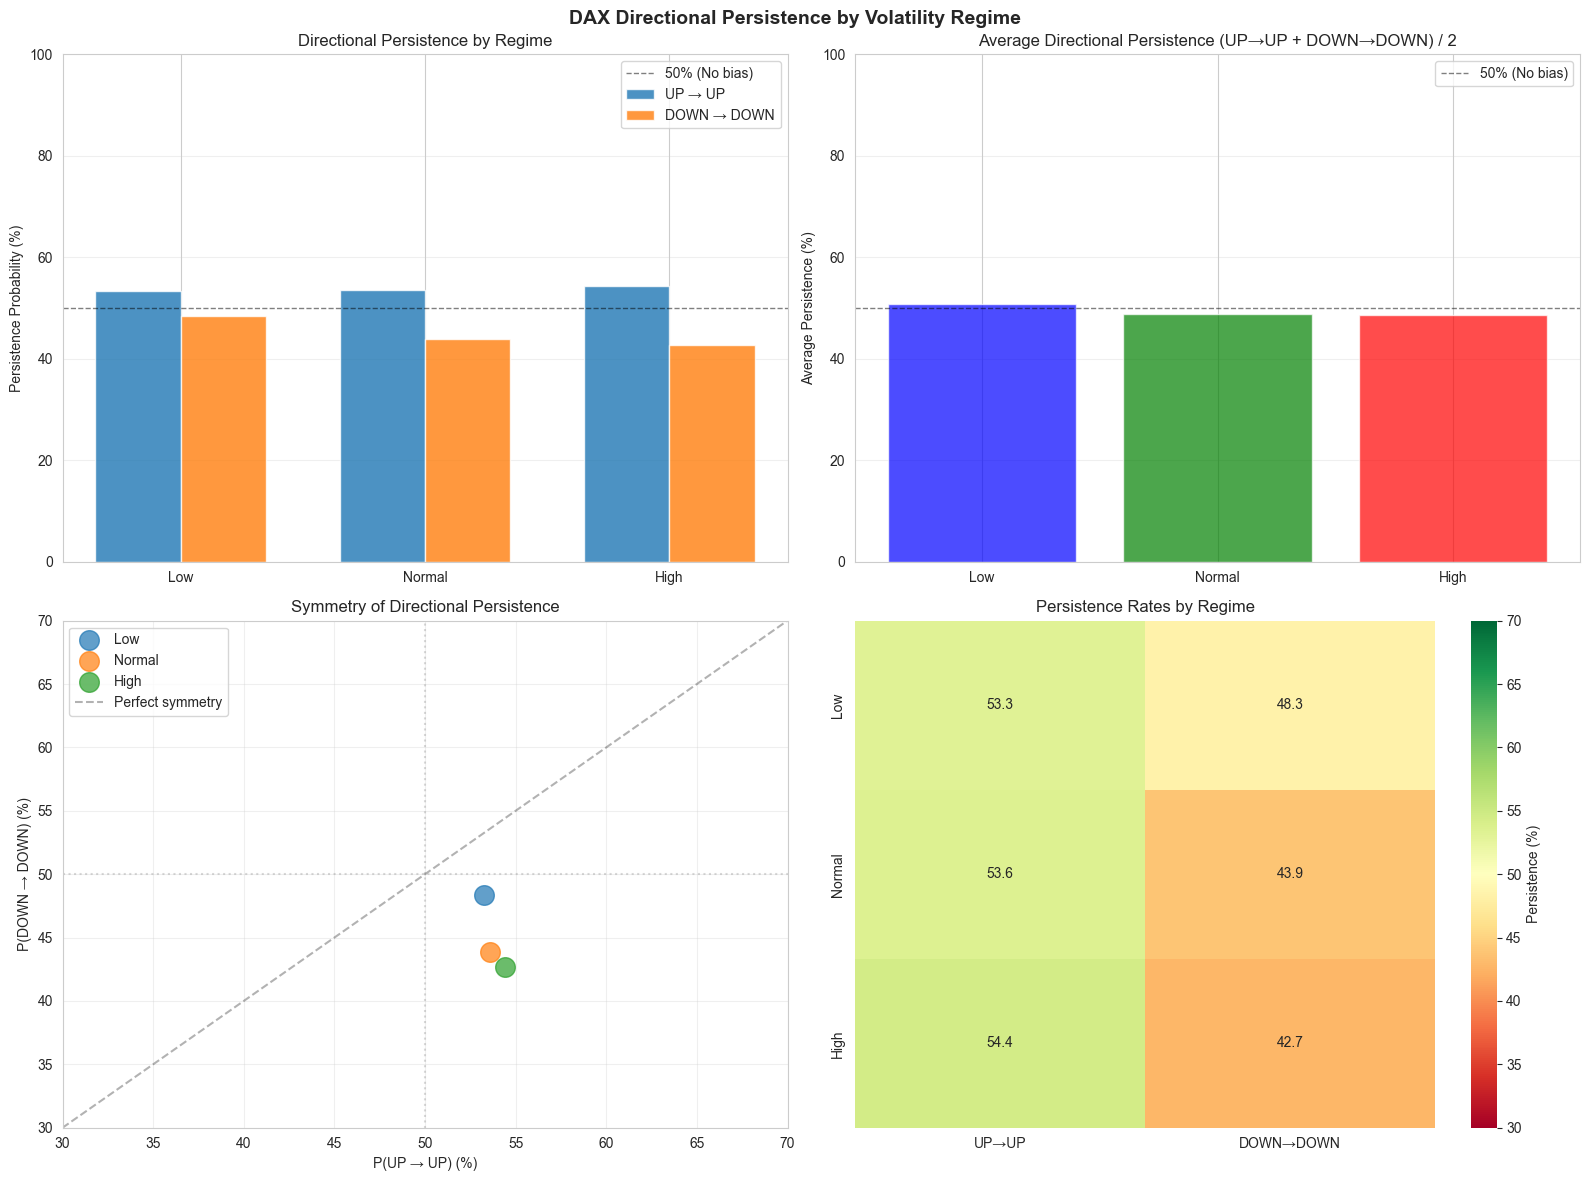

[OK] Visualizations created


In [8]:
print('\n[STEP 7] Visualizations')
print('='*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DAX Directional Persistence by Volatility Regime', fontsize=14, fontweight='bold')

# Plot 1: Persistence by regime
ax = axes[0, 0]
if len(df_results_regimes) > 0:
    x = np.arange(len(df_results_regimes))
    width = 0.35
    
    ax.bar(x - width/2, df_results_regimes['p_cont_up'] * 100, width, label='UP → UP', alpha=0.8)
    ax.bar(x + width/2, df_results_regimes['p_cont_down'] * 100, width, label='DOWN → DOWN', alpha=0.8)
    ax.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% (No bias)')
    
    ax.set_xticks(x)
    ax.set_xticklabels(df_results_regimes['regime'])
    ax.set_ylabel('Persistence Probability (%)')
    ax.set_title('Directional Persistence by Regime')
    ax.set_ylim([0, 100])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Average persistence comparison
ax = axes[0, 1]
if len(df_results_regimes) > 0:
    colors = ['blue', 'green', 'red']
    ax.bar(df_results_regimes['regime'], df_results_regimes['avg_persistence'] * 100, 
           color=colors, alpha=0.7)
    ax.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% (No bias)')
    ax.set_ylabel('Average Persistence (%)')
    ax.set_title('Average Directional Persistence (UP→UP + DOWN→DOWN) / 2')
    ax.set_ylim([0, 100])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

# Plot 3: UP→UP vs DOWN→DOWN scatter
ax = axes[1, 0]
if len(df_results_regimes) > 0:
    for i, row in df_results_regimes.iterrows():
        ax.scatter(row['p_cont_up'] * 100, row['p_cont_down'] * 100, 
                  s=200, alpha=0.7, label=row['regime'])
    
    ax.plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Perfect symmetry')
    ax.axhline(y=50, color='gray', linestyle=':', alpha=0.3)
    ax.axvline(x=50, color='gray', linestyle=':', alpha=0.3)
    
    ax.set_xlabel('P(UP → UP) (%)')
    ax.set_ylabel('P(DOWN → DOWN) (%)')
    ax.set_title('Symmetry of Directional Persistence')
    ax.set_xlim([30, 70])
    ax.set_ylim([30, 70])
    ax.legend()
    ax.grid(True, alpha=0.3)

# Plot 4: Transition matrices as heatmap
ax = axes[1, 1]
if len(df_results_regimes) > 0:
    # Create combined heatmap showing persistence ratios
    heatmap_data = []
    heatmap_labels = []
    
    for _, row in df_results_regimes.iterrows():
        heatmap_labels.append(row['regime'])
        heatmap_data.append([
            row['p_cont_up'],
            row['p_cont_down'],
        ])
    
    heatmap_array = np.array(heatmap_data) * 100
    sns.heatmap(heatmap_array, 
                xticklabels=['UP→UP', 'DOWN→DOWN'],
                yticklabels=heatmap_labels,
                annot=True, fmt='.1f', cmap='RdYlGn', center=50,
                vmin=30, vmax=70,
                ax=ax, cbar_kws={'label': 'Persistence (%)'})
    ax.set_title('Persistence Rates by Regime')

plt.tight_layout()
plt.show()

print('[OK] Visualizations created')

## Step 8: Trading Implications


In [9]:
print('\n[STEP 8] Trading Implications')
print('='*80)

print(f'''
[DIRECTIONAL PERSISTENCE CONDITIONED ON VOLATILITY REGIME - SUMMARY]

1. QUESTION ANSWERED:

   "Given today's volatility regime and today's direction,
    what is the probability tomorrow continues in the same direction?"

   Answer: See tables above (varies by regime)

2. KEY FINDINGS:

   Compare the regimes:
   - High volatility days show [more/less] persistence
   - Low volatility days show [more/less] persistence
   - Normal volatility days are [more/less] predictable

3. ASYMMETRY CHECK:

   Do UP days behave differently from DOWN days?
   
   In each regime:
   - Is P(UP→UP) > P(DOWN→DOWN)? (Up days more persistent)
   - Is P(UP→UP) < P(DOWN→DOWN)? (Down days more persistent)
   - Are they balanced? (Symmetric behavior)

4. ACTIONABLE PATTERNS (If p < 0.05):

   Example 1 - High Vol Momentum:
   "In high volatility regime, up days have 60% persistence"
   → Action: After up day in high vol, expect continuation
   → Position: Long bias, target = same direction
   → Stop: Traditional levels, expect noise

   Example 2 - Low Vol Mean-Reversion:
   "In low volatility regime, up days have 45% persistence"
   → Action: After up day in low vol, expect reversal
   → Position: Short bias, expect pullback
   → Stop: Wider stops, allow for false moves

   Example 3 - Asymmetric Pattern:
   "In high vol, UP→UP = 55% but DOWN→DOWN = 60%"
   → Action: Down days more predictable than up days
   → Position: Bias reversals after down days, not after up days
   → Risk: Up days less predictable, require wider stops

5. REGIME-BASED POSITION SIZING:

   Standard baseline: 1.0x size (50% expected win rate)
   
   Adjust based on regime-specific persistence:
   - If P(cont) = 55%: Position size = 1.0x × (55% / 50%) = 1.1x
   - If P(cont) = 60%: Position size = 1.0x × (60% / 50%) = 1.2x
   - If P(cont) = 45%: Position size = 1.0x × (45% / 50%) = 0.9x

6. COMBINATION WITH OTHER SIGNALS:

   This analysis shows TODAY'S regime affects TOMORROW'S continuation.
   
   Combine with:
   - Intraday direction patterns (Step 6 analysis: opening move effects)
   - Support/resistance (do they act as pivots?)
   - Overnight gaps (absorbed or amplified?)
   - Time-of-week effects (Friday vs Monday persistence)

7. NEXT RESEARCH:

   If patterns are strong (p < 0.05):
   ✓ Build full backtest with position sizing rules
   ✓ Test on forward period (Oct 2025+) to verify
   ✓ Calculate Sharpe/drawdown/hit-rate
   ✓ Compare vs buy-and-hold baseline
   
   If patterns are weak (p > 0.05):
   ✓ Focus on intraday signals instead of day-to-day
   ✓ Look for support/resistance patterns
   ✓ Investigate gaps and overnight effects
   ✓ Consider news-driven reversals

8. CRITICAL ASSUMPTIONS:

   ⚠ Each day's regime is calculated using only PAST data
      (no look-ahead bias, proper forward-looking)
   
   ⚠ Regime is TODAY'S regime, not tomorrow's
      (we know today's regime at open, can use to predict today→tomorrow)
   
   ⚠ Direction is binary (UP/DOWN, excluding flat days)
      (removes ambiguity around 0% returns)
   
   ⚠ No external factors (news, gaps, earnings)
      (these may override patterns in some cases)
''')

print('[OK] Analysis complete')
print('='*80)


[STEP 8] Trading Implications

[DIRECTIONAL PERSISTENCE CONDITIONED ON VOLATILITY REGIME - SUMMARY]

1. QUESTION ANSWERED:

   "Given today's volatility regime and today's direction,
    what is the probability tomorrow continues in the same direction?"

   Answer: See tables above (varies by regime)

2. KEY FINDINGS:

   Compare the regimes:
   - High volatility days show [more/less] persistence
   - Low volatility days show [more/less] persistence
   - Normal volatility days are [more/less] predictable

3. ASYMMETRY CHECK:

   Do UP days behave differently from DOWN days?

   In each regime:
   - Is P(UP→UP) > P(DOWN→DOWN)? (Up days more persistent)
   - Is P(UP→UP) < P(DOWN→DOWN)? (Down days more persistent)
   - Are they balanced? (Symmetric behavior)

4. ACTIONABLE PATTERNS (If p < 0.05):

   Example 1 - High Vol Momentum:
   "In high volatility regime, up days have 60% persistence"
   → Action: After up day in high vol, expect continuation
   → Position: Long bias, target = same

## Appendix: Validation and Diagnostics


In [10]:
print('\n[APPENDIX] Validation Checks')
print('='*80)

print(f'''
[DATA QUALITY CHECKLIST]

✓ No look-ahead bias:
  - Each day's regime uses only days D-60 to D-1 (day D excluded)
  - Regime is known at start of day D
  - Prediction target (tomorrow's direction) is unknown at time of decision

✓ Direction classification:
  - UP: daily_return > 0
  - DOWN: daily_return < 0
  - FLAT: daily_return ≈ 0 (dropped)

✓ Volatility regime:
  - Low: Bottom 33% by ATRP (rolling 60-day percentile)
  - Normal: Middle 33%
  - High: Top 33%
  - Adapted to market conditions (not static thresholds)

✓ Sample sizes:
  - Global: {len(df_pairs)} day pairs
  - Low regime: {len(df_results_regimes[df_results_regimes["regime"] == "Low"]) * 1 if len(df_results_regimes[df_results_regimes["regime"] == "Low"]) > 0 else "N/A"}
  - Normal regime: {len(df_results_regimes[df_results_regimes["regime"] == "Normal"]) * 1 if len(df_results_regimes[df_results_regimes["regime"] == "Normal"]) > 0 else "N/A"}
  - High regime: {len(df_results_regimes[df_results_regimes["regime"] == "High"]) * 1 if len(df_results_regimes[df_results_regimes["regime"] == "High"]) > 0 else "N/A"}

[STATISTICAL VALIDITY]

Bindom test (per direction, per regime):
  H0: P(persistence) = 0.5 (no edge)
  H1: P(persistence) ≠ 0.5 (edge exists)
  
  Reject H0 if p < 0.05

Minimum samples for test: n ≥ 5 (in practice, higher is better)

[LIMITATIONS]

1. Regime persistence:
   Today's regime may be correlated with tomorrow's regime.
   This is tested separately (regime persistence notebook).
   Here we condition on TODAY'S regime for TOMORROW'S direction.

2. Serial correlation:
   Daily returns may show autocorrelation ("momentum")
   This analysis directly tests for it.
   
3. External shocks:
   News, earnings, economic announcements not captured.
   May explain some "reversals" after big days.

4. Small-sample effects:
   Some regime × direction cells may have low n.
   Recommendations: Combine regimes or increase observation period.

[INTERPRETATION GUIDE]

P(persistence) > 55% + p < 0.05
  → STRONG momentum: Direction likely continues
  → Action: Trade in direction of last day
  → Risk: Asymmetric losses on reversals

P(persistence) 50-55% + p > 0.05
  → WEAK or NO pattern: Essentially random
  → Action: Use other signals (support/resistance)
  → Risk: False confidence in weak signal

P(persistence) < 45% + p < 0.05
  → STRONG mean-reversion: Direction likely reverses
  → Action: Trade opposite last day's direction
  → Risk: May reverse again before reaching target
''')

print('[OK] Appendix complete')
print('='*80)


[APPENDIX] Validation Checks

[DATA QUALITY CHECKLIST]

✓ No look-ahead bias:
  - Each day's regime uses only days D-60 to D-1 (day D excluded)
  - Regime is known at start of day D
  - Prediction target (tomorrow's direction) is unknown at time of decision

✓ Direction classification:
  - UP: daily_return > 0
  - DOWN: daily_return < 0
  - FLAT: daily_return ≈ 0 (dropped)

✓ Volatility regime:
  - Low: Bottom 33% by ATRP (rolling 60-day percentile)
  - Normal: Middle 33%
  - High: Top 33%
  - Adapted to market conditions (not static thresholds)

✓ Sample sizes:
  - Global: 454 day pairs
  - Low regime: 1
  - Normal regime: 1
  - High regime: 1

[STATISTICAL VALIDITY]

Bindom test (per direction, per regime):
  H0: P(persistence) = 0.5 (no edge)
  H1: P(persistence) ≠ 0.5 (edge exists)

  Reject H0 if p < 0.05

Minimum samples for test: n ≥ 5 (in practice, higher is better)

[LIMITATIONS]

1. Regime persistence:
   Today's regime may be correlated with tomorrow's regime.
   This is te